# ResNet50

In [1]:
%pip install tensorflow

  Using cached tensorflow-2.16.2-cp312-cp312-win_amd64.whl.metadata (3.3 kB)
  Using cached tensorflow_intel-2.16.2-cp312-cp312-win_amd64.whl.metadata (5.0 kB)
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-24.3.25-py2.py3-none-any.whl.metadata (850 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached h5py-3.11.0-cp312-cp312-win_amd64.whl.metadata (2.5 kB)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached ml_dtypes-0.3.2-cp312-cp312-win_amd64.whl.metadata (20 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached protobuf-4.25.3-cp310-abi3-win_amd64.whl.metadata (541 bytes)
  Using cached termcolor-2.4.0-py3-none-any.whl.metadata (6.1 kB)
  Using cached typing_extensions-4.12.2-py3-none-any.whl.metadat

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import callbacks
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout
from tensorflow.keras.preprocessing import image
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random
import os


In [217]:
# # Mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

## Setup Directory Path and Data Generators

In [5]:
# Directory paths
resnet_train_dir = 'Resized_Dataset/train'
resnet_test_dir = 'Resized_Dataset/test'
# resnet_train_dir = '/content/drive/My Drive/Colab Notebooks/vip/Resized_Dataset/train'
# resnet_test_dir = '/content/drive/My Drive/Colab Notebooks/vip/Resized_Dataset/test'

In [6]:
# Load filenames and labels into a DataFrame
resnet_train_filenames = []
resnet_train_labels = []

for resnet_label in os.listdir(resnet_train_dir):
    resnet_label_path = os.path.join(resnet_train_dir, resnet_label)
    for resnet_filename in os.listdir(resnet_label_path):
        resnet_train_filenames.append(os.path.join(resnet_label_path, resnet_filename))
        resnet_train_labels.append(resnet_label)

resnet_train_df = pd.DataFrame({
    'filename': resnet_train_filenames,
    'label': resnet_train_labels
})

# Split into training and validation sets
resnet_train_split_df, resnet_val_split_df = train_test_split(resnet_train_df, test_size=0.2, random_state=42)

# Load test filenames and labels into a DataFrame
resnet_test_filenames = []
resnet_test_labels = []

for resnet_label in os.listdir(resnet_test_dir):
    resnet_label_path = os.path.join(resnet_test_dir, resnet_label)
    for resnet_filename in os.listdir(resnet_label_path):
        resnet_test_filenames.append(os.path.join(resnet_label_path, resnet_filename))
        resnet_test_labels.append(resnet_label)

resnet_test_df = pd.DataFrame({
    'filename': resnet_test_filenames,
    'label': resnet_test_labels
})

In [7]:
# Data generators
resnet_train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True
)

resnet_test_datagen = ImageDataGenerator(rescale=1./255)

resnet_train_generator = resnet_train_datagen.flow_from_dataframe(
    resnet_train_split_df,
    x_col='filename',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

resnet_val_generator = resnet_train_datagen.flow_from_dataframe(
    resnet_val_split_df,
    x_col='filename',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

resnet_test_generator = resnet_test_datagen.flow_from_dataframe(
    resnet_test_df,
    x_col='filename',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 3431 validated image filenames belonging to 2 classes.
Found 858 validated image filenames belonging to 2 classes.
Found 1073 validated image filenames belonging to 2 classes.


## Building Model

In [8]:
# Load ResNet50 model without top layers
resnet_base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of ResNet50
resnet_x = resnet_base_model.output
resnet_x = GlobalAveragePooling2D()(resnet_x)
resnet_x = Dense(512, activation='relu', kernel_regularizer=l2(0.0005))(resnet_x)
resnet_x = Dropout(0.3)(resnet_x)
resnet_predictions = Dense(1, activation='sigmoid')(resnet_x)

# Define complete model
resnet_model = Model(inputs=resnet_base_model.input, outputs=resnet_predictions)

# Freeze first few layers of the ResNet50 base model
for resnet_layer in resnet_base_model.layers[:30]:
    resnet_layer.trainable = False

# Compile model with an adjusted learning rate
resnet_model.compile(optimizer=Adam(learning_rate=0.00003), loss='binary_crossentropy', metrics=['accuracy'])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step


## Model Training

In [9]:
# Define EarlyStopping and ModelCheckpoint Callbacks
resnet_early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
resnet_checkpoint_path = "./resnet50_checkpoint/checkpoint.keras"
resnet_checkpoint_callback = callbacks.ModelCheckpoint(resnet_checkpoint_path, monitor="val_accuracy", save_best_only=True)

In [10]:
# Train model
resnet_history = resnet_model.fit(
    resnet_train_generator,
    epochs=10,
    validation_data=resnet_val_generator,
    callbacks=[resnet_early_stopping, resnet_checkpoint_callback]
)

Epoch 1/10


C:\Users\user\anaconda3\envs\CDS6334\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


108/108 ━━━━━━━━━━━━━━━━━━━━ 255s 2s/step - accuracy: 0.7929 - loss: 0.8165 - val_accuracy: 0.5093 - val_loss: 1.1951
Epoch 2/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 239s 2s/step - accuracy: 0.9628 - loss: 0.4977 - val_accuracy: 0.6445 - val_loss: 1.0147
Epoch 3/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 237s 2s/step - accuracy: 0.9763 - loss: 0.4688 - val_accuracy: 0.7692 - val_loss: 1.1176
Epoch 4/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 234s 2s/step - accuracy: 0.9892 - loss: 0.4182 - val_accuracy: 0.8392 - val_loss: 0.8722
Epoch 5/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 234s 2s/step - accuracy: 0.9936 - loss: 0.4040 - val_accuracy: 0.9639 - val_loss: 0.4725
Epoch 6/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 219s 2s/step - accuracy: 0.9906 - loss: 0.4082 - val_accuracy: 0.9825 - val_loss: 0.4206
Epoch 7/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 217s 2s/step - accuracy: 0.9918 - loss: 0.3841 - val_accuracy: 0.9930 - val_loss: 0.3762
Epoch 8/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 227s 2s/step - accuracy: 0.9960 - loss: 0.3676 - val_accuracy: 0.989

In [38]:
ResNet_last_epochs = -1  # Placeholder index for the last epoch

# Store training loss from history
resnet_training_loss = resnet_history.history['loss']
resnet_training_acc = resnet_history.history['accuracy']

# Print the stored value (optional)
print(f"Training Loss: {resnet_training_loss}")
print(f"Training Accuracy: {resnet_training_acc}")

Training Loss: [0.665806770324707, 0.4885464608669281, 0.45834192633628845, 0.4187784194946289, 0.4060167968273163, 0.39744168519973755, 0.37716326117515564, 0.36770135164260864, 0.3595273494720459, 0.349257230758667]
Training Accuracy: [0.8872048854827881, 0.9688137769699097, 0.9798892736434937, 0.9892159700393677, 0.9915476441383362, 0.9915476441383362, 0.994462251663208, 0.9950451850891113, 0.9956281185150146, 0.9962109923362732]


In [39]:
%store resnet_training_loss
%store resnet_training_acc

Stored 'resnet_training_loss' (list)
Stored 'resnet_training_acc' (list)


## Model Evaluation

In [11]:
# Evaluate model
resnet_test_loss, resnet_test_acc = resnet_model.evaluate(resnet_test_generator)
print(f"ResNet50 Model Test Accuracy: {resnet_test_acc:.4f}")

# Generate predictions
resnet_test_generator.reset()
resnet_preds = resnet_model.predict(resnet_test_generator)
resnet_preds = np.round(resnet_preds).astype(int).flatten()
resnet_true_labels = resnet_test_generator.classes
resnet_preds_rounded = np.round(resnet_preds).astype(int)
resnet_report = classification_report(resnet_true_labels, resnet_preds_rounded,
                               target_names=resnet_test_generator.class_indices.keys(),
                               digits=4)

# Classification report and confusion matrix
print("ResNet50 Classification Report:")
print(resnet_report)

print("ResNet50 Confusion Matrix:")
resnet_conf_matrix = confusion_matrix(resnet_true_labels, resnet_preds)
print(resnet_conf_matrix)

34/34 ━━━━━━━━━━━━━━━━━━━━ 21s 610ms/step - accuracy: 0.9927 - loss: 0.3728
ResNet50 Model Test Accuracy: 0.9972
34/34 ━━━━━━━━━━━━━━━━━━━━ 22s 610ms/step
ResNet50 Classification Report:
               precision    recall  f1-score   support

Apple_Healthy     1.0000    0.9939    0.9969       488
 Apple_Rotten     0.9949    1.0000    0.9974       585

     accuracy                         0.9972      1073
    macro avg     0.9974    0.9969    0.9972      1073
 weighted avg     0.9972    0.9972    0.9972      1073

ResNet50 Confusion Matrix:
[[485   3]
 [  0 585]]


In [20]:
%store resnet_report

Stored 'resnet_report' (str)


In [22]:
%store resnet_test_acc

Stored 'resnet_test_acc' (float)


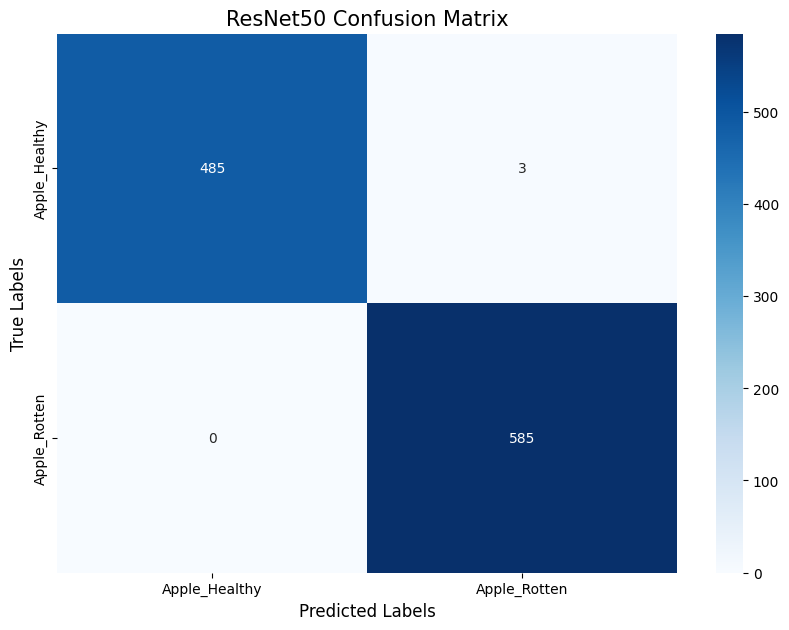

In [17]:
# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(resnet_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=resnet_test_generator.class_indices.keys(), yticklabels=resnet_test_generator.class_indices.keys())
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.title('ResNet50 Confusion Matrix', fontsize=15)
plt.show()

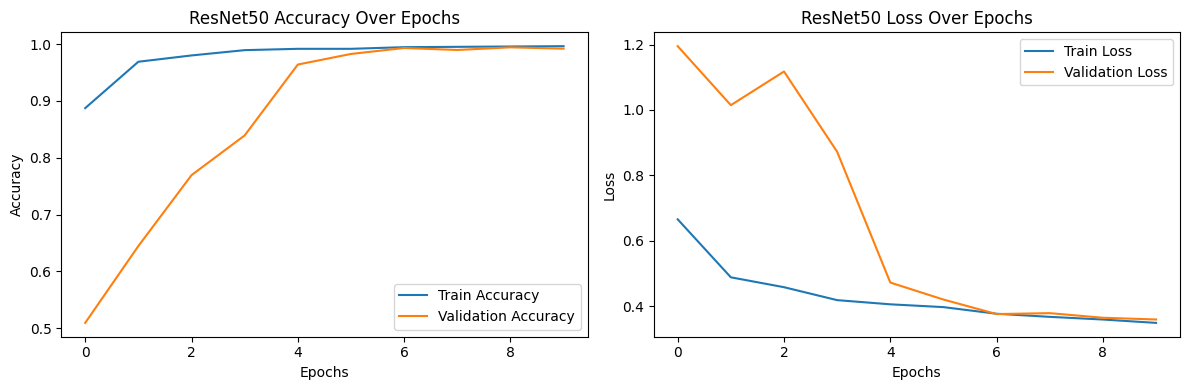

In [18]:
# Plotting Accuracy and Loss over epochs
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(resnet_history.history['accuracy'], label='Train Accuracy')
plt.plot(resnet_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('ResNet50 Accuracy Over Epochs')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(resnet_history.history['loss'], label='Train Loss')
plt.plot(resnet_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('ResNet50 Loss Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

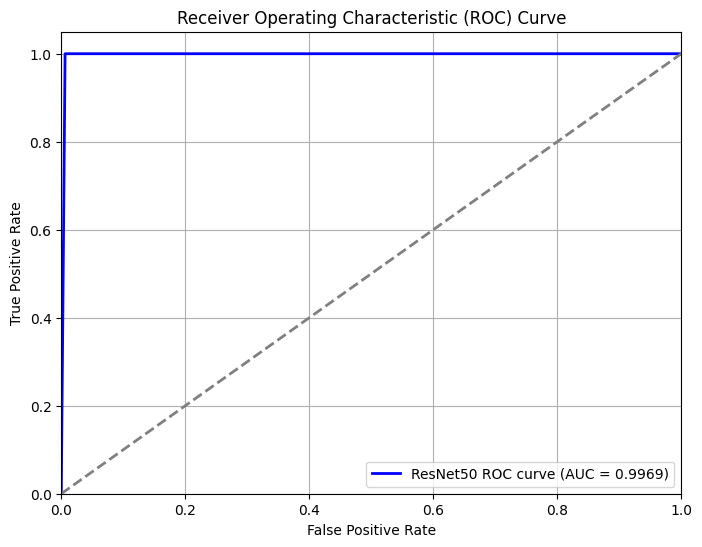

In [64]:
# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(resnet_true_labels, resnet_preds)
ResNet_auc_score = roc_auc_score(resnet_true_labels, resnet_preds)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ResNet50 ROC curve (AUC = {ResNet_auc_score:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [65]:
%store ResNet_auc_score

Stored 'ResNet_auc_score' (float64)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


C:\Users\user\AppData\Local\Temp\ipykernel_14284\3109662768.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  prediction_label = class_labels[int(np.round(prediction))]


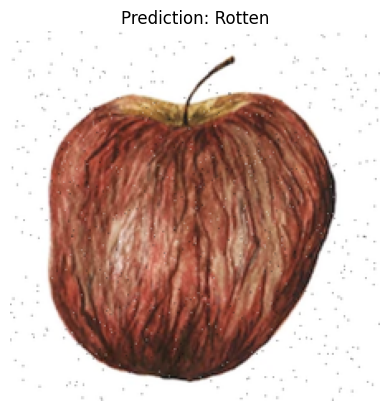

In [62]:
# Function to predict with a random image
def predict_random_image(model, test_dir, class_labels):
    # Get ('Apple_Healthy', 'Apple_Rotten')
    class_dirs = os.listdir(test_dir)

    # Choose random class directory
    random_class = random.choice(class_dirs)
    class_dir = os.path.join(test_dir, random_class)

    # Get all image files in chosen class directory
    all_images = os.listdir(class_dir)

    # Choose random image file
    random_image = random.choice(all_images)
    random_image_path = os.path.join(class_dir, random_image)

    # Load and preprocess the image
    img = image.load_img(random_image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.  # Rescale to [0, 1]

    # Predict class label
    prediction = model.predict(img_array)
    prediction_label = class_labels[int(np.round(prediction))]

    # Display image and prediction
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Prediction: {prediction_label}')
    plt.show()

class_labels = ['Healthy', 'Rotten']
predict_random_image(resnet_model, resnet_test_dir, class_labels)


## Results and Discussion

The outcomes demonstrate that the ResNet50 model achieved strong performance in distinguishing between healthy and rotten apples. Specifically, the model achieved an impressive test accuracy of 99.72% following ten epochs of training. The classification report illustrates high precision, recall, and f1-scores exceeding 99% for both apple categories, resulting in an overall weighted average accuracy of 98.42%. The confusion matrix indicates minimal misclassifications, with only 3 instances of healthy apples being incorrectly labeled as rotten and 0 cases of rotten apples misclassified as healthy.

Initially, the model showed signs of overfitting, evidenced by a notable disparity between training and validation accuracies early on. However, through the implementation of dropout techniques, regularization methods, and augmented data during training, overfitting was effectively mitigated. The early stopping mechanism further ensured that the model retained its best-performing weights, leading to robust performance on the test dataset. These findings suggest that the model can generalize effectively to new datasets, making it a reliable tool for practical applications in assessing apple quality.